In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_run_losses(run_dir):
    log_file = os.path.join(run_dir, "metrics.csv")  # or whatever CSVLogger writes
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"No metrics.csv found in {run_dir}")

    df = pd.read_csv(log_file)

    # Assumes columns: epoch, train_loss, val_loss
    epochs = df["epoch"]
    train_loss = df["train_loss"]
    val_loss = df["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()


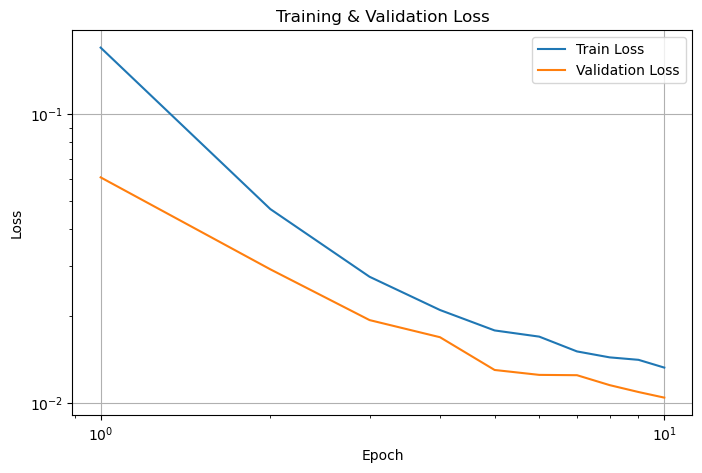

In [6]:
plot_run_losses("/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/demo_runs/2025-11-04_15-48-29/")